In [1]:
import os
import json
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from alpaca_trade_api.rest import REST, TimeFrame
from datetime import datetime

import dask
import dask.bag as db
from dask.diagnostics import ProgressBar

import statsmodels.api as sm 
from typing import Optional , Tuple

import ast

In [2]:
def load_quote_data(symbol: str, date: str) -> pd.DataFrame:
    csv_name = f"{symbol}_{date}_quote.csv"
    quote_data = pd.read_csv(f"data/{csv_name}", sep=",")
    
    # Convert timestamp to datetime, handling potential errors
    try:
        quote_data['timestamp'] = pd.to_datetime(quote_data['timestamp']) 
    except ValueError as e:
        print(f"Error parsing timestamps for {symbol}: {e}")
        # Optionally use coerce to handle this
        quote_data['timestamp'] = pd.to_datetime(quote_data['timestamp'], errors='coerce')
    
    quote_data.set_index('timestamp', inplace=True)
    return quote_data

def calculate_midprice_and_downsample(quote_data : pd.DataFrame , downsample : int) -> pd.Series:
    quote_data["mid_price"] = np.where(
        (quote_data["ask_price"] > 0) & (quote_data["bid_price"] > 0),
        (quote_data["ask_price"] + quote_data["bid_price"]) * 0.5,
        np.nan
    )
    downsampled_mid_price = quote_data["mid_price"].resample(f'{downsample}S').last()
    downsampled_mid_price = downsampled_mid_price.fillna(method='ffill')
    #print(type(downsampled_mid_price))
    return downsampled_mid_price

In [29]:
## Backtesting 

downsample = 60 # time interval for resampling the mid price
k = 2 # Threshold in Bollinger Band to trigger a trade

df_parameters = pd.read_csv(f"parameters/cointPair_params_formation2_ds{downsample}_weighted.csv", sep = ";")
#df_results["Trading Day"] = pd.to_datetime(df_results["Trading Day"], format="%Y%m%d") 


#df_results.set_index("Trading Day", inplace = True)
unique_symbol_list = []
for i in range(len(df_parameters)):
    trade_day = df_parameters["Trading Day"]
    coint_pairs_params_by_day = df_parameters.iloc[i]["Coint Pairs and Params"]
    coint_pairs_params_by_day = ast.literal_eval(coint_pairs_params_by_day)
    unique_symbols_by_day = set()
    for pair in coint_pairs_params_by_day:
        unique_symbols_by_day.add(pair["asset 1"])
        unique_symbols_by_day.add(pair["asset 2"])
    unique_symbol_list.append(unique_symbols_by_day)
df_parameters["Unique Symbols"] = unique_symbol_list
daily_return_list = []

for i in range(len(df_parameters)):
    trade_day = df_parameters.iloc[i]["Trading Day"]
    print(f"Backtesting on {trade_day}")
    if len(df_parameters.iloc[i]["Unique Symbols"]) == 0:
        daily_return_list.append(0)   
        print(f"return is 0")
    else:
        df_mid_price_by_trading_day = pd.DataFrame()
        for symbol in df_parameters.iloc[i]["Unique Symbols"]:
            quote_data_by_symbol = load_quote_data(symbol= symbol, date=trade_day)   
            downsampled_mid_price_by_symbol = calculate_midprice_and_downsample(quote_data = quote_data_by_symbol, downsample = downsample)
            df_mid_price_by_trading_day[symbol] = downsampled_mid_price_by_symbol
        df_mid_price_by_trading_day = df_mid_price_by_trading_day.fillna(method='ffill')
        df_mid_price_by_trading_day = df_mid_price_by_trading_day.fillna(method='bfill')

        coint_pairs_params_by_day = df_parameters.iloc[i]["Coint Pairs and Params"]
        coint_pairs_params_by_day = ast.literal_eval(coint_pairs_params_by_day)
        
        daily_return = 0

        for j in range(len(coint_pairs_params_by_day)):
            
            coint_params = coint_pairs_params_by_day[j]
            asset1 = coint_params["asset 1"]
            asset2 = coint_params["asset 2"]
            #print(f"asset 1 is {asset1} and asset 2 is {asset2}")
            const = coint_params["constant"]
            hedge_ratio = coint_params["hedge ratio"]
            res_mean = coint_params["res mean"]
            res_std = coint_params["res std"]
            df_mid_price_by_trading_day[[asset1, asset2]]
            residual = df_mid_price_by_trading_day[asset2] - ( hedge_ratio * df_mid_price_by_trading_day[asset1] + const)

            period = int(1200 / downsample) # 20 mins 
            #k = 2.5

            df_backtest = pd.DataFrame()
            df_backtest["asset1"] = df_mid_price_by_trading_day[asset1]
            df_backtest["asset2"] = df_mid_price_by_trading_day[asset2]
            residual = df_backtest["asset2"] - ( hedge_ratio * df_backtest["asset1"] + const)
            df_backtest["residual"] = residual

            # Calculate the rolling mean and standard deviation
            residual_rolling_mean = residual.rolling(period).mean()
            residual_rolling_std = residual.rolling(period).std()

            # Calculate the Bollinger Bands
            lower_band = residual_rolling_mean - k * residual_rolling_std
            upper_band = residual_rolling_mean + k * residual_rolling_std

            # Calculate %B

            df_backtest["pert_b"] = (residual - lower_band) / (upper_band - lower_band)

            df_backtest["signal1"] = np.nan
            df_backtest["signal2"] =  np.nan

            df_backtest.reset_index(inplace=True)
            # Generate trading signals
            position = 0  # 1 for long, -1 for short, 0 for neutral

            for h in range(period - 1, len(df_backtest) -1):

                if position == 0:
                    if df_backtest.iloc[h].pert_b <= 0:
                        position =1
                        df_backtest.at[h, "signal1"] = -1
                        df_backtest.at[h, "signal2"] = 1

                    elif df_backtest.iloc[h].pert_b >= 1:
                        position = - 1
                        df_backtest.at[h, "signal1"] = 1
                        df_backtest.at[h, "signal2"] = -1   

                elif position == 1:
                    if  (df_backtest.iloc[h - 1].pert_b < 0.5) and (df_backtest.iloc[h].pert_b >= 0.5): 
                        position = 0
                        df_backtest.at[h, "signal1"] = 0
                        df_backtest.at[h, "signal2"] = 0
                    else:
                        df_backtest.at[h, "signal1"] = np.nan
                        df_backtest.at[h, "signal2"] = np.nan

                        
                elif position == - 1:
                    if (df_backtest.iloc[h - 1].pert_b > 0.5) and (df_backtest.iloc[h].pert_b <= 0.5): 
                        position = 0
                        df_backtest.at[h, "signal1"] = 0
                        df_backtest.at[h, "signal2"] = 0
                    else:
                        df_backtest.at[h, "signal1"] = np.nan
                        df_backtest.at[h, "signal2"] = np.nan

            df_backtest = df_backtest.fillna(method='ffill')
            df_backtest.set_index("timestamp", inplace = True)

            df_backtest['return1'] = df_backtest['asset1'].pct_change()
            df_backtest['return2'] = df_backtest['asset2'].pct_change()

            df_backtest['strategy_return'] = hedge_ratio * df_backtest['signal1'].shift(1) * df_backtest['return1'] + df_backtest['signal2'].shift(1) * df_backtest['return2']

            initial_capital = 1
            df_backtest['equity_curve'] = initial_capital * (1 + df_backtest['strategy_return']).cumprod()

            #df_backtest["equity_curve"].plot();
            pair_daily_return = df_backtest["equity_curve"][-1] - 1
            print(f"return {asset1}-{asset2} pair is {pair_daily_return}")

            daily_return += pair_daily_return
        
        daily_return = daily_return / len(coint_pairs_params_by_day)
        print(f"daily return is {daily_return}")
        daily_return_list.append(daily_return)

df_parameters["return"] = daily_return_list
df_bt_result = df_parameters[["Trading Day", "return"]]
df_bt_result.to_csv(f"backtest-result/bt_result_ds{downsample}_k{k}.csv", sep = ";" ,index = False)

Backtesting on 20240605
return SMH-TSM pair is -0.013897284700950863
return SOXX-TSM pair is -0.020950588122797376
daily return is -0.01742393641187412
Backtesting on 20240606
return SMH-SOXX pair is 0.0060428542381472106
return SMH-AMAT pair is 0.012322690600374386
return AMAT-QCOM pair is 0.018593043531706543
return AMAT-INTC pair is -0.0003672516910465662
daily return is 0.009147834169795394
Backtesting on 20240607
return SMH-SOXX pair is 0.006841809990615788
return SMH-INTC pair is 0.009699866946035085
return SOXX-TSM pair is 0.011024395533422382
return SOXX-INTC pair is 0.009921269790799325
return TSM-INTC pair is 0.006642216994779959
return AMAT-INTC pair is 0.0004591696576661253
daily return is 0.007431454818886444
Backtesting on 20240610
return is 0
Backtesting on 20240611
return is 0
Backtesting on 20240612
return is 0
Backtesting on 20240613
return SMH-TSM pair is -0.010856531335152853
return SOXX-ASML pair is 0.008827623014789454
return SOXX-QCOM pair is 0.004432918155536258

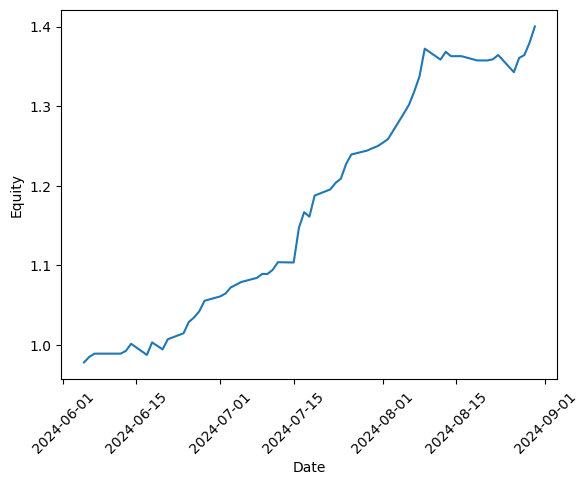

Volatility : 0.009858505113542988
Sharpe Ratio : 8.985574810432993
VaR (95% confidence): -0.010006666869749393
CVaR (95% confidence): -0.015430072240024012
Maximum Drawdown (MDD): -0.021517632601626004
Win-loss ratio : 4.888888888888889


In [16]:
plt.figure()
plt.plot(pd.to_datetime(df_parameters["Trading Day"], format="%Y%m%d"), (1 + df_parameters['return']).cumprod())
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()


vol = df_parameters['return'].std()

sr = df_parameters['return'].mean() / df_parameters['return'].std()  * np.sqrt(252)

# Calculate VaR at 95% confidence level using historical method
confidence_level = 0.95
VaR = np.percentile(np.array(daily_return_list), (1-confidence_level) * 100)

# Calculate CVaR at 95% confidence level
CVaR = np.array(daily_return_list)[np.array(daily_return_list) <= VaR].mean()

# Step 1: Calculate cumulative returns
cumulative_returns = np.cumprod(1 + np.array(daily_return_list))
# Step 2: Calculate the running maximum
running_max = np.maximum.accumulate(cumulative_returns)
# Step 3: Calculate the drawdown
drawdown = (cumulative_returns - running_max) / running_max
# Step 4: Find the maximum drawdown
max_drawdown = np.min(drawdown)

ret = np.array(daily_return_list)
win_loss_ratio = len(ret[ret > 0]) / len(ret[ret < 0]) 

print(f"Volatility : {vol}")
print(f"Sharpe Ratio : {sr}")
print(f"VaR (95% confidence): {VaR}")
print(f"CVaR (95% confidence): {CVaR}")
print(f"Maximum Drawdown (MDD): {max_drawdown}")
print(f"Win-loss ratio : {win_loss_ratio}")

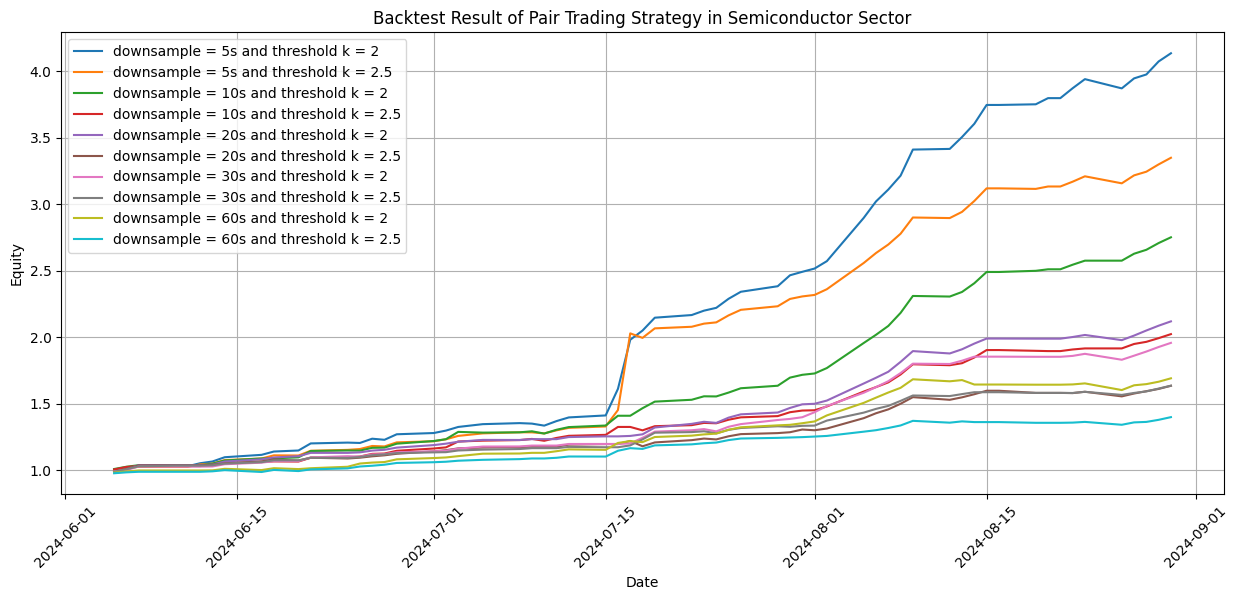

In [40]:
# Initialize the comparison DataFrame properly
df_bt_parameter_comparison = pd.DataFrame(columns=["Downsample", "Threshold", "Average Daily Return", 
                                                   "Volatility", "Sharpe Ratio", "VaR(95% of confidence)", 
                                                   "CVaR(95% of confidence)", "MDD", "Win-loss ratio"])

plt.figure(figsize = (15, 6))

for downsample in [5, 10, 20, 30, 60]:
    for threshold in [2, 2.5]:
        # Read the CSV file
        df_bt_result = pd.read_csv(f"backtest-result/bt_result_ds{downsample}_k{threshold}.csv", sep=";")
        
        # Plot cumulative returns
        plt.plot(pd.to_datetime(df_bt_result["Trading Day"], format="%Y%m%d"), 
                 (1 + df_bt_result['return']).cumprod(), label=f"downsample = {downsample}s and threshold k = {threshold}")
        
        # Extract the return data
        daily_return_list = df_bt_result['return'].values
        
        # Calculate statistics
        mean_ret = daily_return_list.mean()
        vol = daily_return_list.std()
        sr = mean_ret / vol * np.sqrt(252)  # Sharpe Ratio
        
        # VaR at 95% confidence level using the historical method
        confidence_level = 0.95
        VaR = np.percentile(daily_return_list, (1-confidence_level) * 100)
        
        # CVaR at 95% confidence level
        CVaR = daily_return_list[daily_return_list <= VaR].mean()
        
        # Calculate maximum drawdown (MDD)
        cumulative_returns = np.cumprod(1 + daily_return_list)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = np.min(drawdown)
        
        # Calculate Win/Loss ratio
        win_loss_ratio = len(daily_return_list[daily_return_list > 0]) / len(daily_return_list[daily_return_list < 0])
        
        # Create a new row with the calculated metrics
        new_row = {
            "Downsample": downsample,
            "Threshold": threshold,
            "Average Daily Return": mean_ret,
            "Volatility": vol,
            "Sharpe Ratio": sr,
            "VaR(95% of confidence)": VaR,
            "CVaR(95% of confidence)": CVaR,
            "MDD": max_drawdown,
            "Win-loss ratio": win_loss_ratio
        }
        
        # Append the new row to the DataFrame using pd.concat
        df_bt_parameter_comparison = pd.concat([df_bt_parameter_comparison, pd.DataFrame([new_row])], ignore_index=True)

# Plot settings
plt.title("Backtest Result of Pair Trading Strategy in Semiconductor Sector")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Equity")
plt.legend()
plt.grid()
plt.show()


In [39]:
df_bt_parameter_comparison

,Downsample,Threshold,Average Daily Return,Volatility,Sharpe Ratio,VaR(95% of confidence),CVaR(95% of confidence),MDD,Win-loss ratio
0,5,2,0.024159,0.036762,10.432488,-0.002747,-0.009562,-0.017650,10.400000
1,5,2.5,0.021109,0.051706,6.480729,-0.002860,-0.010540,-0.016724,6.125000
2,10,2,0.016913,0.019103,14.054794,-0.000936,-0.005067,-0.013114,9.800000
3,10,2.5,0.011737,0.014847,12.549184,-0.002976,-0.009385,-0.019265,6.714286
4,20,2,0.012514,0.015486,12.827305,-0.006211,-0.011578,-0.019279,6.428571
5,20,2.5,0.008192,0.013499,9.633487,-0.010138,-0.019474,-0.033043,4.200000
6,30,2,0.011186,0.014579,12.179845,-0.002850,-0.012227,-0.023766,6.285714
7,30,2.5,0.008173,0.011381,11.399971,-0.003237,-0.009913,-0.014523,4.666667
8,60,2,0.008771,0.015006,9.278272,-0.009372,-0.019268,-0.048110,4.888889
9,60,2.5,0.005580,0.009777,9.060145,-0.010007,-0.015430,-0.021518,4.888889
